Preparing models for 2 different approaches: tree models and neural networks.
Can bring in the latter after forming some initial hypotheses about how samples are clustered.

Input Data Files:
in ./input_data_files/
- 18Sv4 and 18Sv9 asv counts
- pr2 taxonomy which also integrates the Mixoplankton Database (Mitra et al 2023)
- exclude_samples.txt, samples to filter out of analysis
- new 18Sv4 and 18Sv9 taxonomies on pr2 5.0.0
- metadata file containing "predictor" sample features
- additional Datazoo / Calcofi website files with more environmental predictor features
    - **"High-Performance Liquid Chromatography Pigments (CalCOFI Cruise) subset 2014-2020.csv"**, contains data for cruises (not necessarily the same as the NCOG DNA/RNA collection cruises!)

outputs of this notebook:
- new frequency tables for individual asvs, individual species, and individual functional types. each formatted as such: the samples are rows/observations and the asvs are the "response" features. 
- additional response features: per sample ASV diversity scores, or diversity scores within particular categories.
- "predictor" tables subset from the metadata file, include only the allowed samples and have data for all included samples. there may be cases of NA... not sure how to resolve, may have to go col by col.

Protocols for data:
- [Main CalCofi page for protocols](https://calcofi.org/data/marine-ecosystem-data/e-dna/)
- [Protocols.io sample collection](https://www.protocols.io/view/noaa-calcofi-ocean-genomics-ncog-sample-collection-eq2lypdorlx9/v1)
- [Protocols.io DNA extraction](https://www.protocols.io/view/sterivex-dna-extraction-x54v9m1y4g3e/v2)
- [Protocols.io PCR library prep & barcoding](https://www.protocols.io/view/amplicon-library-preparation-bp2l6b4j5gqe/v1) (primers used are listed here; "quantify with the qubit" (fluorometric... so it can measure amount of DNA but not quantify sequences))
    - [PR2 primer database, try and find them](https://app.pr2-primers.org/pr2-primers/)
- [QIIME protocols on allenlab github & the other data folder](https://github.com/allenlab/QIIME2_18Sv4_ASV_protocol)

### **Reading in input files**

In [1]:
import pandas as pd
import numpy as np

In [2]:
#any functions required by other notebooks have been moved here
#reimport when changing functions
from helper_functions import proportional_frequencies, shannon_index, asv_richness

In [3]:
raw_asv_freqs_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S.tsv", sep = "\t", index_col = 0)
raw_asv_freqs_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax.tsv", sep = "\t", index_col = 0)

asv_taxonomies_18Sv9 = pd.read_csv("input_data_files/18Sv9_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)
asv_taxonomies_18Sv4 = pd.read_csv("input_data_files/18Sv4_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)

pr2_taxonomies = pd.read_csv("input_data_files/pr2_version_5.0.0_taxonomy.tsv", sep = "\t")

samples_to_exclude = pd.read_csv("input_data_files/exclude_samples.txt", skiprows=2)
sample_metadata = pd.read_csv("input_data_files/NCOG_sample_log_DNA_stvx_meta_2014-2020.csv", index_col = 0)

### **Filter out asv counts and rescale to proportions after removing S. pombe**

In [4]:
def sample_mask(samples):
    """Selects only the columns which correspond to valid sample IDs."""
    return [col[0] == "X" and col[1:7].isdigit() and col not in samples_to_exclude for col in samples]

#18Sv4 and v9 do not have the same number of observations (samples).
sample_mask_18Sv4 = sample_mask(raw_asv_freqs_18Sv4.columns)
sample_mask_18Sv9 = sample_mask(raw_asv_freqs_18Sv9.columns)

len(sample_mask_18Sv9), sum(sample_mask_18Sv9),\
len(sample_mask_18Sv4), sum(sample_mask_18Sv4)

(1542, 1486, 1203, 1145)

In [5]:
#use asv taxonomies to find s pombe and remove it
def standard_mask(asv_taxonomies):
    """Returns a row mask excluding ASVs identified as internal standard Schizosaccharomyces pombe."""
    return ["pombe" not in taxon for taxon in asv_taxonomies["Taxon"]]

standard_mask_18Sv9 = standard_mask(asv_taxonomies_18Sv9)
standard_mask_18Sv4 = standard_mask(asv_taxonomies_18Sv4)
len(standard_mask_18Sv9), sum(standard_mask_18Sv9),\
len(standard_mask_18Sv4), sum(standard_mask_18Sv4)

(50408, 50407, 34498, 34496)

In [6]:
#apply row and column masks to each table, then scale proportionally along columns for proportional asv frequencies

asv_freqs_18Sv4 = raw_asv_freqs_18Sv4.loc[standard_mask_18Sv4, sample_mask_18Sv4].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9 = raw_asv_freqs_18Sv9.loc[standard_mask_18Sv9, sample_mask_18Sv9].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9.shape, asv_freqs_18Sv4.shape

((50407, 1486), (34496, 1145))

In [7]:
#only 1% of the cells in both tables have a nonzero value, should only expect useful data by aggregating into
#either species or MFTs... calculate per sample diversity scores for each
#since it's the species or MFT proportions that are going to be the "response features", i don't have to transpose just yet

sum(sum(asv_freqs_18Sv4.values != 0)) / (asv_freqs_18Sv4.index.size * asv_freqs_18Sv4.columns.size),\
sum(sum(asv_freqs_18Sv9.values != 0)) / (asv_freqs_18Sv9.index.size * asv_freqs_18Sv9.columns.size)

(0.014492155536291532, 0.01549514809477769)

### **Environmental feature tables for 18Sv4 and 18Sv9**

Since there's different numbers of samples in each table, these won't be exactly the same.

LightGBM can handle missing values so I'll leave them in.

Not all the metadata is included in the main metadata file. Can import the ones that aren't here (example: "region" category for stations (upwelling region, etc))

In [8]:
#change index so it matches columns of the frequency tables. guessing that qiime adds the X to avoid numerical var names
sample_metadata.index = ["X" + sample_id for sample_id in sample_metadata.index]

In [9]:
#Columns that contain environmental data about a sample-- not just IDs or combos of other variables.
#variables where you wouldn't expect this to make a difference but if it does it'll be good to know: Cast_Type, Cardinal_Sta
#keep lat and long as floats, for tree regression cutoffs
useful_metadata = ["Cast_Type","Cardinal_Sta",
                   "Lat_Dec", "Lon_Dec", 
                   "Bottle_Depth", 
                   "T_degC", 
                   "Salnty", 
                   "STheta", "O2ml_L","PO4ug","SiO3ug","NO3ug","NH3ug","ChlorA","Phaeop",
                   "RecInd","MLD_Sigma"]

#not all the samples have metadata; drop the ones that don't.
#selecting sample metadata rows based on asv_freqs columns (already filtered) excludes the "samples to exclude".
samples_w_data_18Sv4 = asv_freqs_18Sv4.columns[[sample in sample_metadata.index for sample in asv_freqs_18Sv4.columns]]
samples_w_data_18Sv9 = asv_freqs_18Sv9.columns[[sample in sample_metadata.index for sample in asv_freqs_18Sv9.columns]]


In [10]:
#listed sample does not have any corresponding metadata.
for sample in asv_freqs_18Sv4.columns:
    if sample not in sample_metadata.index:
        print(sample)
for sample in asv_freqs_18Sv9.columns:
    if sample not in sample_metadata.index:
        print(sample)
#sum([sample in sample_metadata.index for sample in asv_freqs_18Sv4.columns])

X201904_086.7_035.0_19
X201904_086.7_035.0_19


In [11]:
asv_freqs_18Sv4.columns.shape, samples_w_data_18Sv4.shape

((1145,), (1144,))

In [12]:
asv_freqs_18Sv9.columns.shape, samples_w_data_18Sv9.shape

((1486,), (1485,))

In [13]:
#transform the date and time variables: 
#date should be year/month/season (see how many boosting trees end up splitting on month)
#should these be discrete? does lightgbm treat discrete ints differently from categorical strings?
def split_date(date_series):
    """Takes a series of (M)M/DD/YYYY objects and returns 3 series of year, month, date."""
    finished_variables = {"year":[],"month":[],"season":[]}
    seasons = ["winter", "spring", "summer", "fall"]
    for date in date_series:
        if type(date) == float and np.isnan(date):
            finished_variables["year"].append(np.nan)
            finished_variables["month"].append(np.nan)
            finished_variables["season"].append(np.nan)
        else:
            month, day, year = date.split("/")
            finished_variables["year"].append(int(year))
            finished_variables["month"].append(int(month))
            season_index = (int(month) % 12) // 3 #0, 1, 2, 3
            finished_variables["season"].append(seasons[season_index])
    return pd.DataFrame(finished_variables, index = date_series.index)

timevars_18Sv4 = split_date(sample_metadata.loc[samples_w_data_18Sv4, "Date"])
timevars_18Sv9 = split_date(sample_metadata.loc[samples_w_data_18Sv9, "Date"])

In [14]:
#convert time to minutes since 0000 
def time_to_mins(time):
    """Converts a H:MM, HH:MM, or (H)H:MM:SS string to "minutes since 0000". If time is nan, return nan."""
    if type(time) == float and np.isnan(time):
        return time
    hhmmss = time.split(":")
    return int(hhmmss[0]) * 60 + int(hhmmss[1]) #ignore seconds
        
timevars_18Sv4["Mins_since_0000"] = [time_to_mins(time) for time in sample_metadata.loc[samples_w_data_18Sv4,"Time"]]
timevars_18Sv9["Mins_since_0000"] = [time_to_mins(time) for time in sample_metadata.loc[samples_w_data_18Sv9,"Time"]]

In [15]:
#create environmental features dataframes
#join the time variables: by default a left join (the final table's index will be env_features's index), index on index
env_features_18Sv4 = sample_metadata.loc[samples_w_data_18Sv4, useful_metadata].join(timevars_18Sv4)
env_features_18Sv9 = sample_metadata.loc[samples_w_data_18Sv9, useful_metadata].join(timevars_18Sv9)

In [16]:
with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(env_features_18Sv4)

,Cast_Type,Cardinal_Sta,Lat_Dec,Lon_Dec,Bottle_Depth,T_degC,Salnty,STheta,O2ml_L,PO4ug,SiO3ug,NO3ug,NH3ug,ChlorA,Phaeop,RecInd,MLD_Sigma,year,month,season,Mins_since_0000
X201402_086.7_033.0_10,Prodo,False,33.88950,-118.49250,10.0,14.652000,33.495701,24.888700,5.661,0.48,4.46,1.80,0.51,1.461,0.427,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_086.7_033.0_22,Prodo,False,33.88950,-118.49250,22.0,14.619000,33.494900,24.895889,5.624,0.50,4.59,1.80,0.62,1.333,0.417,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_090.0_037.0_10,Ros,True,33.18017,-118.39332,10.0,15.544000,33.530701,24.721359,5.822,0.34,2.54,0.00,0.01,0.362,0.097,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_037.0_30,Ros,True,33.18017,-118.39332,30.0,14.020000,33.443100,24.982420,5.748,0.48,3.31,1.40,0.02,1.489,0.426,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_053.0_10,Ros,True,32.65117,-119.48417,10.0,14.460000,33.290100,24.770920,5.897,0.37,2.37,0.10,0.05,0.466,0.122,3.0,21.755340,2014.0,2.0,winter,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X202010_093.3_050.0_10,NaN,False,32.17972,-118.89242,10.0,20.429001,33.686600,23.649481,5.350,0.14,1.05,0.18,NaN,0.263,0.103,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_050.0_30,NaN,False,32.17972,-118.89242,29.0,15.711000,33.455700,24.627911,5.594,0.36,2.67,0.93,NaN,1.019,0.542,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_090.0_10,Ross,False,30.84673,-121.59022,10.0,19.943001,33.251400,23.445560,5.388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0
X202010_093.3_090.0_75,Ross,False,30.84673,-121.59022,75.0,13.073000,32.908600,24.763290,6.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0


### **Collate species frequencies and MFT frequencies into response features**

Can also take per sample diversity scores of relevant species as an additional feature.

In [17]:
#e.g. tiarina sp. is NOT just a generic "tiarina". it's a specific cluster of sequences. there could be another species
#is not that one and has a different trophic type. so it still make sense to match by species.
pr2_taxonomies.loc[
    ["sp" in pr2_taxonomies.loc[index, "species"]
     and type(pr2_taxonomies.loc[index, "mixoplankton"]) == str 
     for index in pr2_taxonomies.index]
,["species", "mixoplankton"]]

,species,mixoplankton
3152,Pterosperma_cristatum,CM
45376,Tiarina_sp.,eSNCM
45882,Spirotontonia_sp.,GNCM
46002,Gonyaulax_spinifera,CM
46058,Coolia_sp.,CM
46137,Barrufeta_resplendens,CM
46138,Bispinodinium_angelaceum,CM
46164,Lepidodinium_sp.,CM
46223,Nematodinium_sp.,CM
46264,Blastodinium_sp.,CM


In [18]:
#add the mixo column to each taxonomies object
#pr2_mft = pr2_taxonomies["mixoplankton"]
#pr2_mft.index = pr2_taxonomies["species"]
#pr2_mft.name = "MFT"

pr2_mft = pr2_taxonomies["mixoplankton"]
pr2_mft.index = pr2_taxonomies["species"].values
pr2_mft.name = "MFT"

asv_taxonomies_18Sv4["most_specific_name"] = asv_taxonomies_18Sv4["Taxon"].apply(lambda x : x.strip(";").split(";")[-1])
asv_taxonomies_18Sv9["most_specific_name"] = asv_taxonomies_18Sv9["Taxon"].apply(lambda x : x.strip(";").split(";")[-1])

asv_taxo_mft_18Sv4 = asv_taxonomies_18Sv4.join(pr2_mft, on="most_specific_name").loc[asv_freqs_18Sv4.index]
asv_taxo_mft_18Sv9 = asv_taxonomies_18Sv9.join(pr2_mft, on="most_specific_name").loc[asv_freqs_18Sv9.index]

In [19]:
#v9 vs. v4: which has more ASVs and higher confidence on classifications? that may vary!
display(asv_taxo_mft_18Sv4.loc[ [mft == "GNCM" for mft in asv_taxo_mft_18Sv4["MFT"]] ])
display(asv_taxo_mft_18Sv9.loc[ [mft == "GNCM" for mft in asv_taxo_mft_18Sv9["MFT"]] ])

,Taxon,Confidence,most_specific_name,MFT
Feature.ID,,,,
060dd2edd76a5d6438877037bf434f89,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.998480,Spirotontonia_sp.,GNCM
0726c31f1edc57782c5f1d0298a9405d,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.954496,Pseudotontonia_simplicidens,GNCM
10e5f49f7f0ba38a2315fa0cf1d9047a,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.978661,Pseudotontonia_simplicidens,GNCM
1fd9139ba70c4960568515186e739719,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.751422,Pseudotontonia_simplicidens,GNCM
4827f0c16d707123cd741f481dbd29c9,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.980069,Pseudotontonia_simplicidens,GNCM
5f08d10ff8f5aa9176c2eb350dfdb494,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999735,Strombidium_capitatum,GNCM
660f154283b35ec0c146df61b47f85ff,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.851679,Strombidium_capitatum,GNCM
6689d55504861f52f17d349543f32eb1,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.926887,Laboea_strobila,GNCM
71e50e9f5f73e9405a8ab640525bae55,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.997365,Pseudotontonia_simplicidens,GNCM


,Taxon,Confidence,most_specific_name,MFT
Feature.ID,,,,
2abfa726d24e90ca55757ffc54fa69ac,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999998,Strombidium_chlorophilum,GNCM
3fb5b10bb9245ace83ef6e068430669e,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999657,Spirotontonia_sp.,GNCM
7bb04f20f6ad13b9ab18937da914f9b1,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.872572,Laboea_strobila,GNCM
7cc774ff1f66d9270f3f06b18e605b54,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.979331,Spirotontonia_sp.,GNCM
b734f84365fe560e470b162af90a2e96,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999157,Spirotontonia_sp.,GNCM
d34e8e3f680dc45e7fbc7b64fb1362c9,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.965355,Spirotontonia_sp.,GNCM
ee1074fc2331d04d28c796cb16057e75,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.962011,Spirotontonia_sp.,GNCM


In [20]:
asv_freqs_18Sv4.shape, asv_freqs_18Sv9.shape

((34496, 1145), (50407, 1486))

In [21]:
env_features_18Sv4.shape, env_features_18Sv9.shape

((1144, 21), (1485, 21))

In [22]:
#v4 has more species classified in CM and GNCM, v9 has more in pSNCM and eSNCM - interesting.
#from here on out, should keep doing the steps for v4 and v9
for mft in ["CM", "GNCM", "pSNCM", "eSNCM"]:
    print(
        asv_taxo_mft_18Sv4.loc[asv_taxo_mft_18Sv4["MFT"] == mft].shape,
        asv_taxo_mft_18Sv9.loc[asv_taxo_mft_18Sv9["MFT"] == mft].shape,
    )
#test.loc[ ["Dinophysis_ac" in name for name in test["most_specific_name"] ] ]

(470, 4) (450, 4)
(22, 4) (7, 4)
(4, 4) (15, 4)
(84, 4) (158, 4)


### **Adding more environmental features - matching HPLC data to NCOG cruises**

In many cases it may not be an exact match for the cruise month/depth, so 1) pick the closest option 2) add a flag describing the problem.

Need to add 2 extra columns to HPLC data: 1) an "index" column which can be left-joined onto other environmental features (specifically join to env_features_18Sv4 and v9 - not to sample_metadata!), or at least contain NULL 2) a "flag" column saying if it was an exact match for month/depth or not
- **this may not be totally accurate: check the date-times on HPLC data and on the sample_metadata file. they actually do match, or are very close.**

want exact match on year, line, station

how to keep 2 HPLC samples from matching the exact same NCOG sample? - or, how to replace a worse match witha better one?

In [23]:
from datetime import datetime
import re

In [24]:
#this is a comma sep file
hplc_data = pd.read_csv("input_data_files/High-Performance Liquid Chromatography Pigments (CalCOFI Cruise) subset 2014-2020.csv",
                       #index_col = 0
                       )

#can't make index_col = 0 because index is actually identical for every row in the same cruise.
hplc_data.index = [hplc_data.iloc[i]["studyName"] + f"_s{i}" for i in range(hplc_data.index.size)]

In [25]:
datetime(year = 2014, month = 5, day = 6, hour = 23, minute = 23, second = 23) \
- datetime(year = 2014, month = 5, day = 6, hour = 23, minute = 23, second = 22)

datetime.timedelta(seconds=1)

In [26]:
#if no match, re.match gives None
re.match("[0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2}",
         "2014-01-29 05:11:05"),\
re.match("[0-9]{,2}/[0-9]{,2}/[0-9]{4} [0-9]{,2}:[0-9]{2}",
         "1/29/2014 18:30")

(<re.Match object; span=(0, 19), match='2014-01-29 05:11:05'>,
 <re.Match object; span=(0, 15), match='1/29/2014 18:30'>)

In [27]:
def convert_datetime_ncog(datetime_str):
    #some of this might be NA or wrong format: if so, return a flag that will end main method early
    if type(datetime_str) != str \
    or re.match("[0-9]{,2}/[0-9]{,2}/[0-9]{4} [0-9]{,2}:[0-9]{2}", datetime_str) == None:
        return -1
    
    #otherwise, break according to format "1/29/2014 18:30"
    month, day, year, hour, minute = (int(s) for s in re.split("/| |:", datetime_str))
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute)

In [28]:
abs_delta = abs(hplc_data["Datetime GMT"].apply(datetime.fromisoformat) - convert_datetime_ncog("1/29/2014 18:30"))
sum([delta.total_seconds() < 3*3600 for delta in abs_delta])

1

In [29]:
#sorting key for timedelta objects automatically sorts the smallest deltas first!
abs_delta.sort_values()

2014-01-28-C-325S_s4         0 days 00:00:56
2014-01-28-C-325S_s3         0 days 03:01:07
2014-01-28-C-325S_s5         0 days 04:11:57
2014-01-28-C-325S_s2         0 days 05:47:22
2014-01-28-C-325S_s6         0 days 07:57:29
                                 ...        
2020-10-11-C-33SR_s1109   2456 days 11:21:17
2020-10-11-C-33SR_s1110   2456 days 14:47:46
2020-10-11-C-33SR_s1111   2456 days 14:47:46
2020-10-11-C-33SR_s1112   2459 days 00:42:34
2020-10-11-C-33SR_s1113   2459 days 00:42:34
Name: Datetime GMT, Length: 1114, dtype: timedelta64[ns]

In [30]:
#fill dataframe
def match_ncog_hplc_indices(row):
    """Point of this method is less to match hplc data exactly with DNA extraction 
    (they might have just not happened at the same time), but to match with an hplc sample
    that is as representative as possible of the location, depth, and time that DNA extraction happened"""
    #name of each row in env_features is an ncog index
    ncog_index = row.name
    #assuming that line comes first...
    ncog_line, ncog_station = (float(s) for s in sample_metadata.loc[ncog_index, "Sta_ID"].split(" "))
    #depth.... just be within 5 (?) meters, try with "Bottle_Depth" and "Depthm".
    ncog_depth = sample_metadata.loc[ncog_index, "Bottle_Depth"]
    
    #selection from hplc_data: 
    #matches line and station exactly... within 5m of depth
    subset_mask = [hplc_data.loc[index, "Line"] == ncog_line \
                   and hplc_data.loc[index, "Station"] == ncog_station \
                   and abs(hplc_data.loc[index, "Depth (m)"] - ncog_depth) < 15 \
                  for index in hplc_data.index]
    #subset the relevant hplc_rows: those in correct location and depth
    hplc_subset = hplc_data.loc[subset_mask]
    
    #print(ncog_index, ncog_line, ncog_depth)
    #print(hplc_subset[["Line", "Station", "Depth (m)"]])
    
    #convert datetime to datetime.datetime, but only if it is valid input
    #if datetime is valid, convert
    ncog_datetime = convert_datetime_ncog(datetime_str=sample_metadata.loc[ncog_index, "DateTime"])
    if ncog_datetime == -1 or hplc_subset.empty:
        return row #new row = original row, unaltered
    
    #rank hplc rows by how close the datetimes are: the best option will be assigned, unless 
    #it's already in the dataframe, in which case we assign the second best or etc. option;
    #do not consider any options that are more than 4 hours away from ncog_datetime
    ranked_abs_delta = abs(hplc_subset["Datetime GMT"].apply(datetime.fromisoformat) - ncog_datetime).sort_values()
    
    #print(ranked_abs_delta)
    
    #for each HPLC entry in this ranked subset:
    for hplc_index in ranked_abs_delta.index:
        #if the entry is 4 hours or more away from the current ncog entry, discard
        abs_delta = ranked_abs_delta.loc[hplc_index] 
        if abs_delta.total_seconds() > 4*3600:
            return row #new row = original row, no HPLC entry found
        #if not, is hplc_index already used elsewhere? this is the same as asking for a diff. row
        #of the current frame's column but there's no way of knowing that. at some point if the depth,
        #time, etc all match then you should just go for it
        #if hplc_index in join_env_features_18Sv4["HPLC_index"]:
        #    continue
        #else:
        row_iloc = int(re.split("_s", hplc_index)[1]) #extracts the row # from ID string
        return pd.Series([hplc_index] + list(hplc_data.iloc[row_iloc,12:]),
                        index = row.index) #new row includes HPLC index

pigment_columns = ["HPLC_index"] + list(hplc_data.iloc[:,12:].columns.values)

#prepare blank dataframe to fill
pigment_features_18Sv4 = pd.DataFrame(np.zeros( (env_features_18Sv4.index.size, len(pigment_columns)), dtype=str ), 
                                        index = env_features_18Sv4.index,
                                        columns = pigment_columns)
pigment_features_18Sv9 = pd.DataFrame(np.zeros( (env_features_18Sv9.index.size, len(pigment_columns)), dtype=str ), 
                                        index = env_features_18Sv9.index,
                                        columns = pigment_columns)

### Investigating the samples that couldn't be paired

Seem to be cases where NCOG molecular sampling happened and HPLC didn't, on particular lines/stations during particular cruises, or at particular depths.

Consider cases like "X201402_093.3_030.0_10". Even where there is a corresponding entry in pigment dataset, Peridinin features are NaN.

Might be better to not use these as features or to only do so on the tree models.

In [31]:
#apply function with whole series
pigment_features_18Sv4 = pigment_features_18Sv4.apply(match_ncog_hplc_indices, axis = 1)
pigment_features_18Sv9 = pigment_features_18Sv9.apply(match_ncog_hplc_indices, axis = 1)
#can then join columns of hplc_data to this provisional dataframe along "HPLC_index", then join that to env_features...?

#large minority of samples still have no secondary pigments matched... more individual test cases needed.
sum(pigment_features_18Sv9["HPLC_index"] == ""), pigment_features_18Sv9.index.size,\
sum(pigment_features_18Sv4["HPLC_index"] == ""), pigment_features_18Sv4.index.size

(693, 1485, 524, 1144)

In [32]:
#(this is a series and has an index: pigment_features_18Sv9["HPLC_index"] == ""
#sample_metadata.loc[(pigment_features_18Sv9["HPLC_index"] == "").index, "Sta_ID"].unique()

#line and cruise numbers for NCOG samples which were never paired with pigment data
#.loc can only be used on a frame of the same size, from that can extract index of varying sizes, and finally
#a list of varying lengths
unpaired_row_ids = pigment_features_18Sv9.loc[(pigment_features_18Sv9["HPLC_index"] == "")].index.values

line_numbers = sample_metadata.loc[unpaired_row_ids, "Sta_ID"].apply(
    lambda x: float(x.split(" ")[0]))
station_numbers = sample_metadata.loc[unpaired_row_ids, "Sta_ID"].apply(
    lambda x: float(x.split(" ")[1]))
cruisenums = sample_metadata.loc[unpaired_row_ids, "Cruise"]

for cruise in cruisenums.unique():
    cruise_line_numbers = line_numbers.loc[(cruisenums == cruise)]
    cruise_st_numbers = station_numbers.loc[(cruisenums == cruise)]
    print(cruise, cruise_line_numbers.sort_values().unique())
    print(cruise, cruise_st_numbers.sort_values().unique())
    

#cruisenums = sample_metadata.loc[(pigment_features_18Sv9["HPLC_index"] == "").index, "Cruise"]

#pd.DataFrame({
#    "line#":line_numbers,
#    "cruise#":cruisenums
#}).drop_duplicates()
#.unique()

201402 [93.3]
201402 [ 30.  60. 100.]
201404 [76.7 83.3 86.7 93.3]
201404 [ 40.  45.  51.  70.  80. 110.]
201407 [76.7 81.8 83.3 86.7 93.3]
201407 [ 26.7  42.   45.   46.9  49.   50.   51.   70.   80.   90.  110.  120. ]
201411 [76.7 81.8 83.3 86.7 93.3]
201411 [ 26.7  42.   45.   46.9  50.   60.   80.   90.  100.  120. ]
201501 [76.7 83.3 86.7 93.3]
201501 [ 26.7  30.   40.   42.   60.   70.   80.  100.  110. ]
201504 [76.7 81.8 83.3 86.7 90.  93.3]
201504 [ 26.7  45.   46.9  51.   60.   70.   80.   90.  120. ]
201507 [76.7 83.3 86.7 93.3]
201507 [ 26.7  45.   51.   55.   80.   90.  100. ]
201511 [76.7 83.3 86.7 93.3]
201511 [ 33.  40.  42.  49.  60.  70.  80. 110.]
201601 [76.7 83.3 86.7 93.3]
201601 [ 26.7  40.6  45.   60.   70.   80.  100.  110.  120. ]
201604 [76.7 83.3 86.7 90.  93.3]
201604 [ 26.7  37.   40.   45.   60.   70.   80.  100.  110.  120. ]
201607 [76.7 83.3 86.7 93.3]
201607 [ 26.7  40.   45.   55.   70.   90.  100.  110. ]
201611 [76.7 83.3 86.7 93.3]
201611 [ 26.7 

In [33]:
mask = [sample_metadata.loc[index, "Cruise"] == 201402 
        and sample_metadata.loc[index, "Sta_ID"].split(" ")[0] == "093.3"
        and sample_metadata.loc[index, "Sta_ID"].split(" ")[1] == "030.0"
        for index in sample_metadata.index]
with pd.option_context("display.max_columns", None):
    display(sample_metadata.loc[mask])

,sample_num,Cruise,Event,Order_Occ,Sta_ID,Cast_Type,Cardinal_Sta,Station_Notes,Date,Time,DateTime,Lat_Dec,Lon_Dec,Bottle,Assoc_Bottle,Bottle_Depth,Depthm,Del_Depth,Bottle_Notes,NCOG_DNA,NCOG_RNA,DNA_VolFilt,RNA_VolFilt,Pump_Speed,DNA_RNA_Vol_Notes,Filt_Str,Filt_End,Filt_Str_Notes,Filt_End_Notes,Gly.Sample,Sterivex_Notes,std_18S,Distance,T_degC,Salnty,STheta,O2ml_L,PO4ug,SiO3ug,NO3ug,NH3ug,ChlorA,Phaeop,RecInd,MLD_Sigma,NCDepth
X201402_093.3_030.0_39,ND0001,201402,50.0,5,093.3 030.0,Prodo,False,NaN,1/29/2014,18:30,1/29/2014 18:30,32.84617,-117.533,16,16,40.0,39.0,-1.0,NaN,TRUE,TRUE,1.04,1.356,330,not enough water but filter has some color,1311.0,1317,NaN,NaN,NaN,NaN,NaN,-15.356,14.906,33.491001,24.832439,5.841,0.38,2.99,0.0,0.18,0.637,0.215,3.0,14.925865,44.347826
X201402_093.3_030.0_10,ND0002,201402,50.0,5,093.3 030.0,Prodo,False,NaN,1/29/2014,18:30,1/29/2014 18:30,32.84617,-117.533,21,20,10.0,10.0,0.0,NaN,TRUE,TRUE,1.04,2.140,330,NaN,1311.0,1321,NaN,NaN,NaN,NaN,NaN,-15.356,16.111,33.582699,24.633989,5.812,0.34,2.09,0.2,NaN,0.286,0.059,3.0,14.925865,44.347826
X201402_093.3_030.0_39_S,ND1151,201402,50.0,5,093.3 030.0,Prodo,False,NaN,1/29/2014,18:30,1/29/2014 18:30,32.84617,-117.533,16,16,40.0,39.0,-1.0,NaN,TRUE,TRUE,1.04,1.356,330,not enough water but filter has some color,1311.0,1317,NaN,NaN,NaN,NaN,3.78,-15.356,14.906,33.491001,24.832439,5.841,0.38,2.99,0.0,0.18,0.637,0.215,3.0,14.925865,44.347826
X201402_093.3_030.0_10_S,ND1152,201402,50.0,5,093.3 030.0,Prodo,False,NaN,1/29/2014,18:30,1/29/2014 18:30,32.84617,-117.533,21,20,10.0,10.0,0.0,NaN,TRUE,TRUE,1.04,2.140,330,NaN,1311.0,1321,NaN,NaN,NaN,NaN,3.78,-15.356,16.111,33.582699,24.633989,5.812,0.34,2.09,0.2,NaN,0.286,0.059,3.0,14.925865,44.347826


In [34]:
#Line 
with pd.option_context("display.max_columns", None):
    display(hplc_data.loc[[
    hplc_data.loc[index, "studyName"][:7] in ["2014-01"]
    and 
    hplc_data.loc[index, "Line"] in [93.3]
    and hplc_data.loc[index, "Station"] == 30.0
    for index in hplc_data.index]])

,studyName,Datetime GMT,Latitude (º),Longitude (º),Line,Station,Cast Number,Bottle Number,Associated Bottle Number,Depth (m),Quality Control flag,Total chlorophyll a (Goericke_SIO) (µg/L),Total chlorophyll a (UMCES) (µg/L),Chlorophyll a (Goericke_SIO) (µg/L),Chlorophyll a (UMCES) (µg/L),Divinyl chlorophyll a (Goericke_SIO) (µg/L),Divinyl chlorophyll a (UMCES) (µg/L),Chlorophyllide a (Goericke_SIO) (µg/L),Chlorophyllide a (UMCES) (µg/L),Total chlorophyll b (Goericke_SIO) (µg/L),Total Chlorophyll b (UMCES) (µg/L),Chlorophyll b (Goericke_SIO) (µg/L),Chlorophyll b (UMCES) (µg/L),Divinyl Chlorophlyll b (UMCES) (µg/L),Total Chlorophyll c (Goericke_SIO) (µg/L),Total Chlorophyll c (UMCES) (µg/L),Chlorophyll c (Goericke_SIO) (µg/L),Chlorophyll c 1 (Goericke_SIO) (µg/L),Chlorophyll c 2 (Goericke_SIO) (µg/L),Chlorophyll c 12 (UMCES) (µg/L),Chlorophyll c 3 (Goericke_SIO) (µg/L),Chlorophyll c 3 (UMCES) (µg/L),Phaeophorbide a (UMCES) (µg/L),Pheophytin a (UMCES) (µg/L),Peridinin (Goericke_SIO) (µg/L),Peridinin (UMCES) (µg/L),19'-butanoyloxyfucoxanthin (Goericke_SIO) (µg/L),19'-butanoyloxyfucoxanthin (UMCES) (µg/L),Fucoxanthin (Goericke_SIO) (µg/L),Fucoxanthin (UMCES) (µg/L),Neoxanthin (Goericke_SIO) (µg/L),Neoxanthin (UMCES) (µg/L),Prasinoxanthin (Goericke_SIO) (µg/L),Prasinoxanthin (UMCES) (µg/L),Violaxanthin (Goericke_SIO) (µg/L),Violaxanthin (UMCES) (µg/L),19'-hexanoyloxyfucoxanthin (Goericke_SIO) (µg/L),19'-hexanoyloxyfucoxanthin (UMCES) (µg/L),Diadinoxanthin (Goericke_SIO) (µg/L),Diadinoxanthin (UMCES) (µg/L),Alloxanthin (Goericke_SIO) (µg/L),Alloxanthin (UMCES) (µg/L),Diatoxanthin (Goericke_SIO) (µg/L),Diatoxanthin (UMCES) (µg/L),Zeaxanthin (Goericke_SIO) (µg/L),Zeaxanthin (UMCES) (µg/L),Lutein (UMCES) (µg/L),Gyroxanthin diester (UMCES) (µg/L),Carotene (Goericke_SIO) (µg/L),Carotene (UMCES) (µg/L)
2014-01-28-C-325S_s4,2014-01-28-C-325S,2014-01-29 18:30:56,32.85,-117.53,93.3,30.0,5,20,20,10,0,0.374912,NaN,0.269899,NaN,0.105012,NaN,NaN,NaN,0.020723,NaN,0.020723,NaN,NaN,0.024843,NaN,0.001874,NaN,0.017166,NaN,0.005804,NaN,NaN,NaN,NaN,NaN,0.025992,NaN,0.016716,NaN,0.001839,NaN,NaN,NaN,0.000471,NaN,0.093372,NaN,0.030669,NaN,0.002671,NaN,0.002649,NaN,0.069007,NaN,NaN,NaN,0.010945,NaN


In [35]:
#pigment_features_18Sv4.loc[pigment_features_18Sv4["HPLC_index"] == ""]
pigment_features_18Sv4.loc["X201402_093.3_030.0_10"]

HPLC_index                                          2014-01-28-C-325S_s4
Total chlorophyll a (UMCES) (µg/L)                                   NaN
Chlorophyll a (Goericke_SIO) (µg/L)                             0.269899
Chlorophyll a (UMCES) (µg/L)                                         NaN
Divinyl chlorophyll a (Goericke_SIO) (µg/L)                     0.105012
Divinyl chlorophyll a (UMCES) (µg/L)                                 NaN
Chlorophyllide a (Goericke_SIO) (µg/L)                               NaN
Chlorophyllide a (UMCES) (µg/L)                                      NaN
Total chlorophyll b (Goericke_SIO) (µg/L)                       0.020723
Total Chlorophyll b (UMCES) (µg/L)                                   NaN
Chlorophyll b (Goericke_SIO) (µg/L)                             0.020723
Chlorophyll b (UMCES) (µg/L)                                         NaN
Divinyl Chlorophlyll b (UMCES) (µg/L)                                NaN
Total Chlorophyll c (Goericke_SIO) (µg/L)          

**Per sample species proportions - defunct section**

Don't actually need all these to be calculated ahead of time, can select the asvs matching "most specific name" we want for desired species later

### **Extracting dino-only species proportions and MFT proportions**

Should be able to use the same methods as for all species.

### **Alpha diversity & "composability" of pandas & helper functions**

Want to apply different diversity scores to different datasets? Generate dataset by transforming the basic data then apply desired function. Mix & match different row selector lists & apply functions to resulting subsets.

Faith PD over ASVs for: dino ASVs. (Genetic saturation: distance trees not as effective for more distantly related organisms)
Shannon over ASVs for: all ASVs, dino ASVs.

Shannon diversity function defined in "helper_functions.py".

In [36]:
#can start doing some introductory analysis
#make a scatterplot of all ASV shannon, dino shannon, and dino CM shannon against... 
#idk for the first two it should be pan-dino proportion of all ASVs and for dino CM it can be CM proportion of all dinos
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
#selects only ASVs which were classified (Naive Bayes) as CM dinoflagellate species.
dino_mask_18Sv4 = ["Dinoflagellata" in asv_taxo_mft_18Sv4.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv4.index]
CM_mask_18Sv4 = asv_taxo_mft_18Sv4["MFT"] == "CM"

dino_mask_18Sv9 = ["Dinoflagellata" in asv_taxo_mft_18Sv9.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv9.index]
CM_mask_18Sv9 = asv_taxo_mft_18Sv9["MFT"] == "CM"

In [38]:
response_features_18Sv4 = pd.DataFrame({
    "within_dino_CM_diversity" : asv_freqs_18Sv4.loc[dino_mask_18Sv4] #select only the rows corresponding to dinos
                                    .apply(proportional_frequencies, axis = 0) #rescale proportions in terms of dinos only
                                    .loc[CM_mask_18Sv4] #select only the rows corresponding to CMs
                                    .apply(shannon_index), #per sample shannon index
    "within_dino_CM_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4]
                                .apply(proportional_frequencies, axis = 0)
                                .loc[CM_mask_18Sv4]
                                .apply(sum, axis = 0) * 100, #per sample sum of frequencies * 100%
    "within_sample_dino_CM_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4]
                                        .apply(sum, axis = 0) * 100,
    "within_dino_diversity" : asv_freqs_18Sv4.loc[dino_mask_18Sv4]
                                .apply(proportional_frequencies, axis = 0)
                                .apply(shannon_index, axis = 0),
    "within_sample_dino_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(sum, axis = 0) * 100

}, index = asv_freqs_18Sv4.columns)

response_features_18Sv9 = pd.DataFrame({
    "within_dino_CM_diversity" : asv_freqs_18Sv9.loc[dino_mask_18Sv9] #select only the rows corresponding to dinos
                                    .apply(proportional_frequencies, axis = 0) #rescale proportions in terms of dinos only
                                    .loc[CM_mask_18Sv9] #select only the rows corresponding to CMs
                                    .apply(shannon_index), #per sample sum
    "within_dino_CM_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9]
                                .apply(proportional_frequencies, axis = 0)
                                .loc[CM_mask_18Sv9]
                                .apply(sum, axis = 0) * 100,
    "within_sample_dino_CM_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9]
                                        .apply(sum, axis = 0) * 100,
    "within_dino_diversity" : asv_freqs_18Sv9.loc[dino_mask_18Sv9]
                                .apply(proportional_frequencies, axis = 0)
                                .apply(shannon_index, axis = 0),
    "within_sample_dino_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(sum, axis = 0) * 100
}, index = asv_freqs_18Sv9.columns)

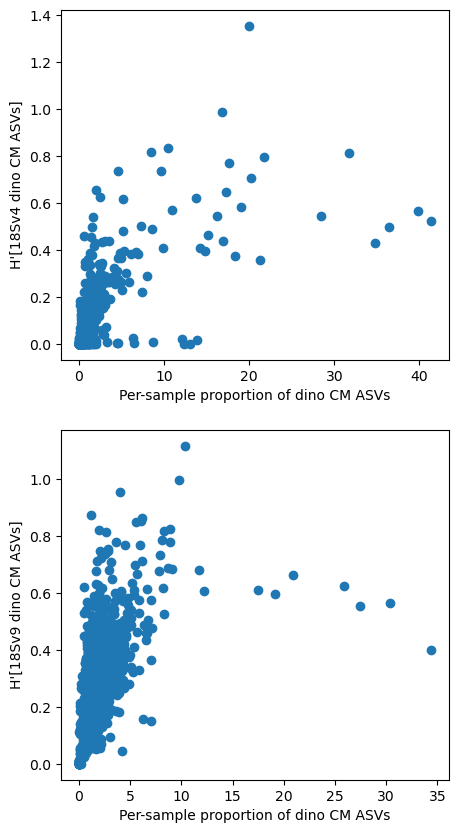

In [39]:
#if ASV proportion of the total sample corresponds with biomass, then I shouldn't ever have "proportion of subset"
#as the x axis
#customizability problems: the only real solution is not trying to create anything ahead of time and just having
#standard procedures for generating all required features from the basic "asv_freqs" and "asv_taxo_mft" using
#pandas methods and helper methods

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    #Y axis: shannon index within the subset "dinoflagellate CMs": select dino ASVs, redo proportional frequencies,
    #select CMs, then shannon? ok wow this worked
    #y=dino_eco_features_18Sv4["dino_CM_shannon"],
    y=response_features_18Sv4["within_dino_CM_diversity"],
    #X axis: summed ASV per-sample proportions (sum along column, collapse rows) for "dinoflagellate CMs"
    x=response_features_18Sv4["within_sample_dino_CM_percent"]
)
ax[0].set_ylabel("H'[18Sv4 dino CM ASVs]")
ax[0].set_xlabel("Per-sample proportion of dino CM ASVs")

ax[1].scatter(
    y=response_features_18Sv9["within_dino_CM_diversity"],
    x=response_features_18Sv9["within_sample_dino_CM_percent"]
)
ax[1].set_ylabel("H'[18Sv9 dino CM ASVs]")
ax[1].set_xlabel("Per-sample proportion of dino CM ASVs")

plt.show()

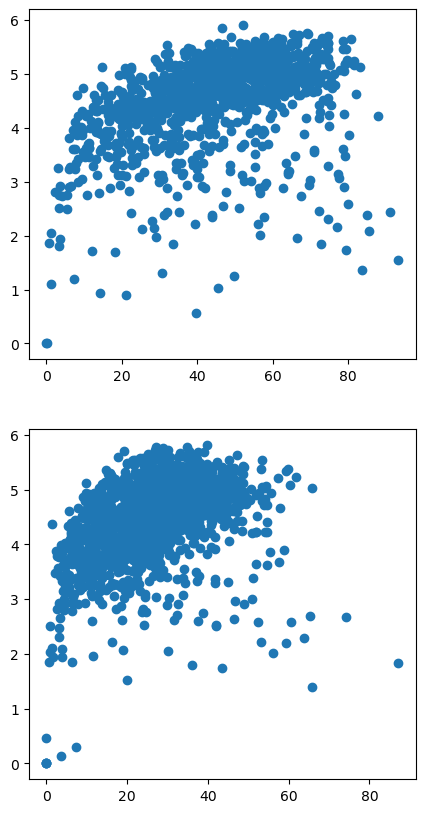

In [40]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: Shannon index of dinos only, with proportions rescaled so dino freqs sum to 1.
    y=response_features_18Sv4["within_dino_diversity"],
    #X axis: per-sample summed proportion for dino ASVs.
    x=response_features_18Sv4["within_sample_dino_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_dino_diversity"],
    x=response_features_18Sv9["within_sample_dino_percent"]
)
plt.show()

### Species richness (number of ASVs) vs proportion of ASVs

In [41]:
#reread dan et al 2024, this metric doesn't actually mean anything - neither do the other ones based on ASVs. 
#they calculate jaccard dissimilarities, another paper did resampling curves I think
#for now just stick to predicting percents
response_features_18Sv4["within_sample_dino_CM_ASVs"] = asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4].apply(asv_richness, axis = 0)
response_features_18Sv4["within_sample_dino_ASVs"] = asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(asv_richness, axis = 0)

response_features_18Sv9["within_sample_dino_CM_ASVs"] = asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9].apply(asv_richness, axis = 0)
response_features_18Sv9["within_sample_dino_ASVs"] = asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(asv_richness, axis = 0)

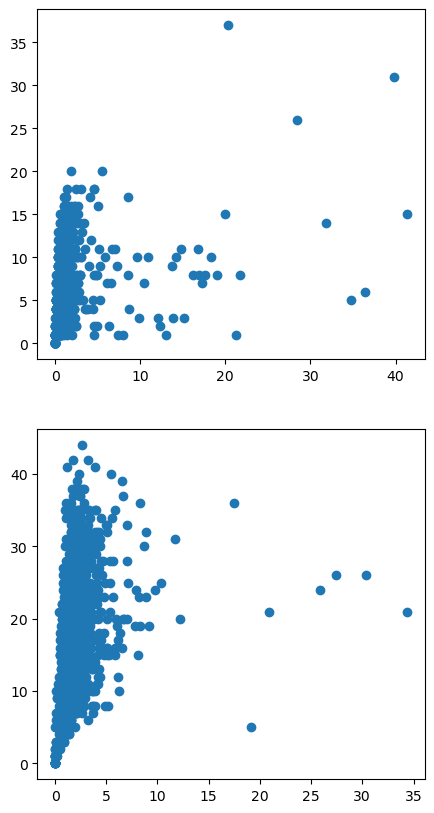

In [42]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

#species richness = # nonzero ASVs *per column* in selected rows

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=response_features_18Sv4["within_sample_dino_CM_ASVs"], 
    #X axis: per sample summed proportion of dino CMs
    x=response_features_18Sv4["within_sample_dino_CM_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_sample_dino_CM_ASVs"], 
    x=response_features_18Sv9["within_sample_dino_CM_percent"]
)
plt.show()

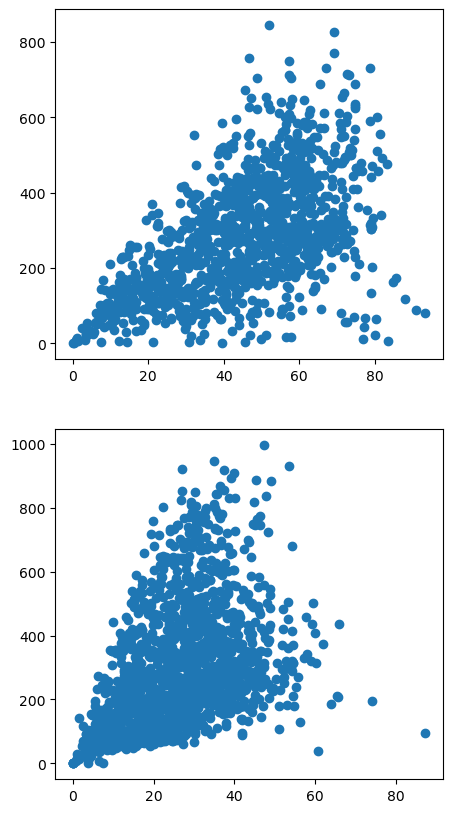

In [43]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=response_features_18Sv4["within_sample_dino_ASVs"], 
    #X axis: per sample summed proportion of dino CMs
    x=response_features_18Sv4["within_sample_dino_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_sample_dino_ASVs"], 
    x=response_features_18Sv9["within_sample_dino_percent"]
)
plt.show()

### Using Chlorophyll & Peridinin for biomass 

First evidence so far for negative correlation (but heteroscedastic) of dino diversity and biomass... except it's not even dino biomass.
check datazoo for peridinin. env feature "Phaeop" = phaeophytin, 2ndary pigment for diatoms.

**NOW WITH PERIDININ**: similar heteroscedastic downward sloping pattern, steeper slope on 18Sv9 proportions than 18Sv4... what could it mean.

In [44]:
env_features_18Sv4["ChlorA"].shape,\
asv_freqs_18Sv4.loc[dino_mask_18Sv4].shape

#X201904_086.7_035.0_19 doesn't have any metadata, dropped from both env_features tables

((1144,), (19821, 1145))

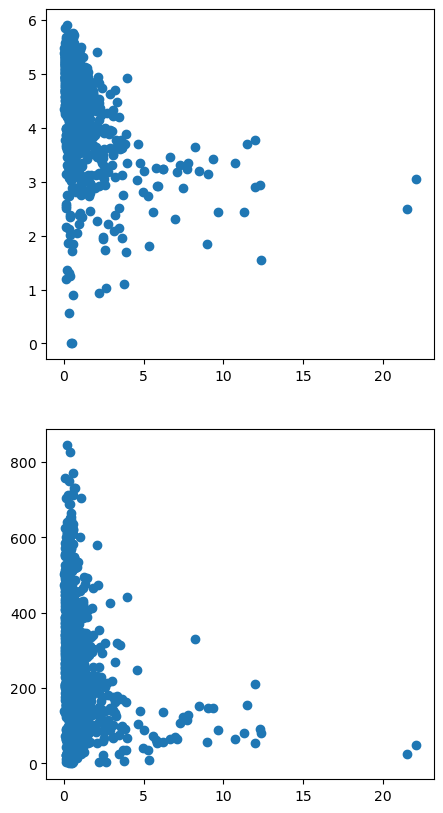

In [45]:
fig, ax = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    #asv_freqs_18Sv4.loc[dino_mask_18Sv4, env_features_18Sv4.index].apply(asv_richness, axis = 0),
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

plt.show()

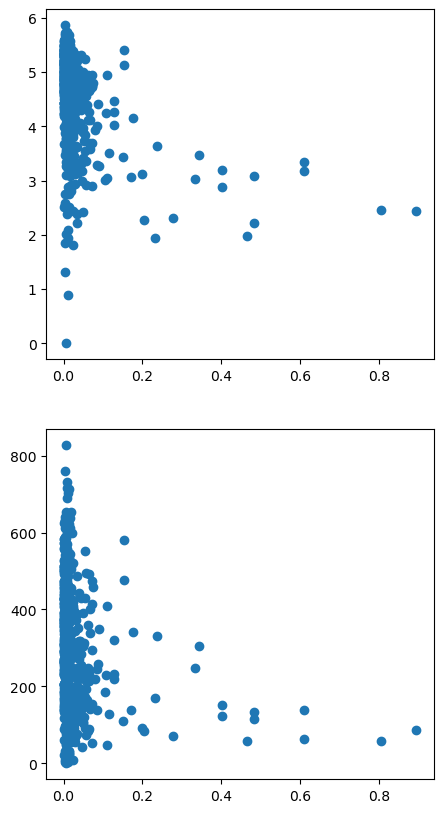

In [46]:
fig, ax = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (UMCES) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (UMCES) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

plt.show()

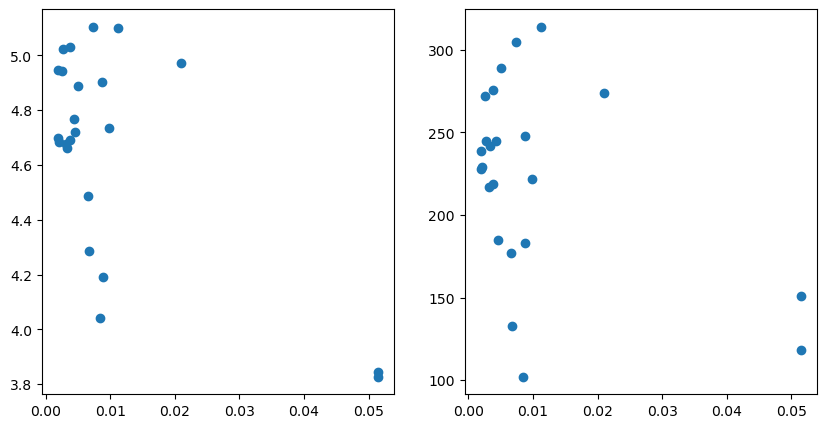

In [47]:
fig, ax = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(10)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (Goericke_SIO) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (Goericke_SIO) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

plt.show()

### **outputs and next steps**

want to use the GBM to... if it can't fully summarize the relationship by itself, it could at least point to which variables would make the most interesting scatterplots, especially for comparing v9 and v4.

decide what to export and why in order to perform the above 4 tests and whatever other tests you want to do.

export env_features, asv_taxo_mft, and asv_freqs. can compose them with helper functions into desired response variables. 

In [48]:
asv_freqs_18Sv4.to_csv("_out_asv_freqs_18Sv4.tsv", sep = "\t")
asv_freqs_18Sv9.to_csv("_out_asv_freqs_18Sv9.tsv", sep = "\t")
asv_taxo_mft_18Sv4.to_csv("_out_asv_taxo_mft_18Sv4.tsv", sep = "\t")
asv_taxo_mft_18Sv9.to_csv("_out_asv_taxo_mft_18Sv9.tsv", sep = "\t")
env_features_18Sv4.to_csv("_out_env_features_18Sv4.tsv", sep = "\t")
env_features_18Sv9.to_csv("_out_env_features_18Sv9.tsv", sep = "\t")
pigment_features_18Sv4.to_csv("_out_pigment_features_18Sv4.tsv", sep = "\t")
pigment_features_18Sv9.to_csv("_out_pigment_features_18Sv9.tsv", sep = "\t")
response_features_18Sv4.to_csv("_out_response_features_18Sv4.tsv", sep = "\t")
response_features_18Sv9.to_csv("_out_response_features_18Sv9.tsv", sep = "\t")

In [49]:
assert(False)

AssertionError: 

**cool dataframe properties**

In [ ]:
row_mask = asv_taxo_mft_18Sv4["most_specific_name"] == "Eukaryota"
asv_freqs_18Sv4.loc[ row_mask ].apply(sum, axis = 0)

In [ ]:
np.zeros((2,3))

In [ ]:
pd.DataFrame({"A":[1,2,3]}, index=[0,1,2]).apply(lambda x: [x+1, x+2, x+3], axis=1)

In [ ]:
pd.Series(["a;a","b;b","c;c"]).map(lambda x : x.split(";")[-1] )

In [ ]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "right"
)

In [ ]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "left"
)

In [ ]:
asv_taxo_mft_18Sv4.shape, asv_taxo_mft_18Sv9.shape

In [ ]:
asv_taxo_mft_18Sv9